## Aprendizaje Profundo - Deep Learning Architectures
### Emilio Alejandro Pérez Cerrillo | 18 de mayo de 2024

#### Introducción
<p style='text-align: justify'> 
De acuerdo con Bergmann and Stryker (2023), un <b>autoencoder</b> o autocodificador se define como un tipo de arquitectura de red neuronal diseñada para comprimir eficientemente datos de entrada hasta sus características más esenciales, proceso llevado a cabo por un <b>encoder</b> o codificador, para posteriormente mediante un <b>decoder</b> o decodificador, reconstruir la entrada original a partir de su representación comprimida. 
</p>

<p style='text-align: justify'> 
Según Sancho Caparrini (2020), los Variational Autoencoders o autocodificadores variacionales son modelos de aprendizaje que utilizan redes neuronales en conjunto con distribuciones de probabilidad. Cabe mencionar que los autoencoders son un método de compresión con pérdida, pero los VAEs son capaces de generar datos sintéticos que siguen los patrones aprendido de los datos con que se entrenan.
</p>

<p style='text-align: justify'> 
De manera general, después de la compresión los VAEs mapean las salidas del encoder a un espacio de dimensión menor al original que sigue una distribución probabílista conocida, por ejemplo una distribución Gaussiana. Esta representación es conocida como <b>espacio latente</b>. Posteriomente, los elementos de este espacio son alimentados al decoder para su recontrucción. Para el entrenamiento se utiliza el mismo conjunto de datos como entradas y las salidas esperadas, ya que se busca que este modelo sea capaz de representar lo más fielmente posible los datos, con la ventaja de poder utilizar el decoder para generar nuevos datos a futuro. 
</p>

<p style='text-align: justify'> 
En este documento, se explorará la implementación de un variational autoencoder (vae) utilizando el framework <b>Keras</b> y el conjunto de imágenes <b>Fashion MNIST</b>, revisando a detalle partes del código para terminar con la presentación de conclusiones. Se espera que su revisión resulte tan interesante como su realización.  
</p>

In [15]:
# framework
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import ops
from keras.layers import Dense, Flatten, Conv2D, Reshape, Conv2DTranspose, Lambda

# otros
import numpy as np
from matplotlib import pyplot as plt

<p style='text-align: justify'> 
Despúes de cargar las librerías necesarias para su ejecución, definimos la <b>dimensión latente</b> a utilizar, así como la longitud por lado de las imágenes.
</p>

In [16]:
dim_latente = 64 # Reducción del 91.21%
lado = 28

#### Importación del dataset 

<p style='text-align: justify'> 
Cargamos las imágenes que contiene el conjunto de fashio MNIST. Se cuenta con 60000 elementos para entrenamiento y 10000 para validación, por la naturaleza del modelo en esta ocasión no las salidas esperadas son iguales a la entrada.  
</p>

In [17]:
(X_tr, _), (X_ts, _) = keras.datasets.fashion_mnist.load_data()
assert X_tr.shape == (60000, lado, lado)
assert X_ts.shape == (10000, lado, lado)

X_tr = np.array(X_tr)
X_ts = np.array(X_ts)

X_tr = np.expand_dims(X_tr, -1).astype("float32") / 255
X_ts = np.expand_dims(X_ts, -1).astype("float32") / 255

#### Muestra de las imágenes originales
<p style='text-align: justify'> 
Con fines ilustrativos, a continuación se muestran algunos de los elementos del conjunto de entrenamiento.
</p>

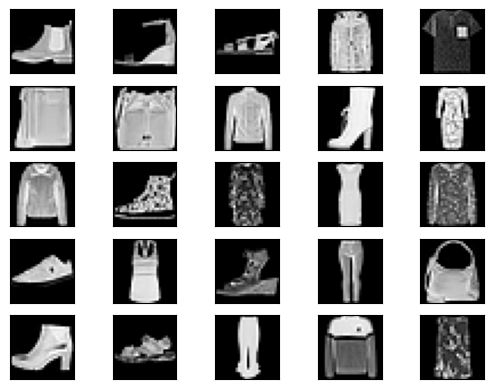

In [24]:
fig, axs = plt.subplots(5, 5)

for i in range(5):
        for j in range(5):
            a = np.random.randint(0, 60000)
            axs[i, j].imshow(X_tr[a], cmap = 'gray')
            axs[i, j].get_xaxis().set_visible(False)
            axs[i, j].get_yaxis().set_visible(False)

plt.show()

#### Declaración de la clase Variational Autoencoder (VAE)

<p style='text-align: justify'> 
Como se mencionó anteriormente, el VAE se compone de un encoder y un decoder. En esta implementación se optó por agrupar todos en una sola clase por simplicidad. 
</p>


El **encoder** cuenta con: 
  - una capa de entrada que toma la forma de los datos, 
  - tres capas convolucionales de 2 dimensiones con 64, 32 y 16 neuronas respectivamente, función de activación ReLU y stride igual a 2 con el propósito de reducir la dimensionalidad de los datos de manera progresiva, 
  - una capa de aplanado para generar vectores lineales y
  - tres capas de salida del tamaño del espacio latente referidas como `z_media`, `z_estdev` y `z` respectivamente. Las primeras dos serán interpretadas como la media y desviación estándar de los datos y a partir de estas se obtendrá la capa `z` cuyo resultado es un vector que siga la distribución normal (proceso que se lleva a cabo en la función sampling).


Por su parte, el **decoder** se compone de:
  - una capa de entrada con la forma del espacio latente,
  - una capa oculta densamente conectada para extender el vector,
  - una capa de remodelado para que la información comience a tomar la forma deseada,
  - tres capas convolucionales de 2 dimensiones con 16, 32 y 64 neuronas respectivamente, función de activación ReLU y stride igual a dos con el propósito de aumentar la dimensionalidad de los datos de manera progresiva,
  - una capa de salida con función de activación sigmoide, apropiada ya que nuestros datos se mantienen entre 0 y 1.
 

Finalmente, el **autoencoder** toma como entradas los datos y como salidas el decoder composición encoder.

<p style=text-align: justify'>
Durante el paso de entrenamiento se lleva acabo una función de pérdida personalizada, donde se toma la divergencia de Kullback-Leibler como factor. De acuerdo con Sancho Caparrini (2020) esta técnica mide la diferencia entre dos distribuciones probabilística, por lo tanto, el modelo buscará minimizarla provocando que los datos sigan una distribución normal.</p>

<p style=text-align: justify'>
Mediante herramientas del framework comunicamos los gradientes de la pérdida al entrenamiento.
</p>


In [28]:
class VAE(tf.keras.Model):
    
    def __init__(self, shape, dim_latente_vae, **kwargs):
        super().__init__(**kwargs)
        self.shape = shape
        self.dim_latente = dim_latente_vae
        self.encoder = None
        self.decoder = None
        self.autoencoder = None 
        
        # Indicadores de pérdida
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    # Función sampling
    def Sampling(self, x):
        z_media_s, z_estdev_s = x
        epsilon = tf.keras.backend.random_normal(shape=(ops.shape(z_media_s)[0], ops.shape(z_media_s)[1]), mean=0, stddev=0.1)
        
        return z_media_s + ops.exp(0.5 * z_estdev_s) * epsilon

    # Constructor
    def build(self):
        # ENCODER
        encoder_inputs = keras.Input(shape=self.shape, name='enc_input')
        h = Conv2D(64, 2, strides=2, padding="same", activation ="relu", name='enc_64')(encoder_inputs)
        h = Conv2D(32, 2, strides=2, padding="same", activation ="relu", name='enc_32')(h)
        h = Conv2D(16, 2, strides=2, padding="same", activation ="relu", name='enc_16')(h)
        h = Flatten(name='aplanado')(h)
        z_media = Dense(self.dim_latente, name="z_media")(h)
        z_estdev = Dense(self.dim_latente, name="z_estdev")(h)
        
        z = Lambda(self.Sampling)([z_media, z_estdev])
        self.encoder =  keras.Model(encoder_inputs, [z_media, z_estdev, z], name="encoder")
        self.encoder.summary()
        
        # DECODER
        dec_entradas = keras.Input(shape=(self.dim_latente,), name='dec_entradas')
        x = Dense(7 * 7 * 64, name='dec_rec')(dec_entradas)
        x = Reshape((7, 7, 64), name='forma')(x)
        x = Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu", name='dec_16')(x)
        x = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu", name='dec_32')(x)
        x = Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu", name='dec_64')(x)
        dec_salidas = Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name='dec_salidas')(x)
        
        self.decoder = keras.Model(dec_entradas, dec_salidas, name="decoder")
        self.decoder.summary()
        
        self.autoencoder = keras.Model(encoder_inputs, self.decoder(self.encoder(encoder_inputs)[2]),name="VAE")
        self.autoencoder.summary()
        
        return None
    
    # Predicción del VAE
    def predict(self, inputs):
        return self.autoencoder.predict(inputs, verbose=0)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # Paso del entrenamiento
    def train_step(self, entradas):
        with tf.GradientTape() as tape:
            z_media, z_estdev, z = self.encoder(entradas)
            salidas = self.decoder(z)
            perdida_salidas = ops.mean(ops.sum(keras.losses.binary_crossentropy(entradas, salidas), axis=(1, 2),))
            
            perdida_kl = -0.5 * (1 + z_estdev - ops.square(z_media) - ops.exp(z_estdev))
            perdida_kl = ops.mean(ops.sum(perdida_kl, axis=1))
            
            perdida_total = perdida_salidas + perdida_kl
            
        # reportar progreso
        gradientes = tape.gradient(perdida_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradientes, self.trainable_weights))
        self.total_loss_tracker.update_state(perdida_total)
        self.reconstruction_loss_tracker.update_state(perdida_salidas)
        self.kl_loss_tracker.update_state(perdida_kl)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def get_encoder(self):
        if self.encoder is not None:
            return self.encoder
        else:
            print("El encoder no se ha declarado")
            return None
    
    def get_decoder(self):
        if self.decoder is not None:
            return self.decoder
        else:
            print("El decoder no se ha declarado")
            return None
        
    def get_autoencoder(self):
        if self.autoencoder is not None:
            return self.autoencoder
        else:
            print("El autoencoder no se ha declarado")
            return None
    

#### Declaración y entrenamiento del modelo.

In [29]:
vae = VAE(X_tr[0].shape, dim_latente)
vae.build()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_tr, epochs=100)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_input           │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_64 (Conv2D)     │ (None, 14, 14,    │        320 │ enc_input[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_32 (Conv2D)     │ (None, 7, 7, 32)  │      8,224 │ enc_64[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_16 (Conv2D)     │ (None, 4, 4, 16)  │      2,064 │ enc_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aplanado (Flatten)  │ (None, 256)       │          0 │ enc_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_media (Dense)     │ (None, 64)        │     16,448 │ aplanado[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_estdev (Dense)    │ (None, 64)        │     16,448 │ aplanado[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64)        │          0 │ z_media[0][0],    │
│                     │                   │            │ z_estdev[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,504 (169.94 KB)

 Trainable params: 43,504 (169.94 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dec_entradas (InputLayer)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_rec (Dense)                 │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forma (Reshape)                 │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_16 (Conv2DTranspose)        │ (None, 14, 14, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_32 (Conv2DTranspose)        │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_64 (Conv2DTranspose)        │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_salidas (Conv2DTranspose)   │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,785 (924.94 KB)

 Trainable params: 236,785 (924.94 KB)

 Non-trainable params: 0 (0.00 B)

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_input (InputLayer)          │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 64), (None,    │        43,504 │
│                                 │ 64), (None, 64)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       236,785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,289 (1.07 MB)

 Trainable params: 280,289 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - kl_loss: 3.1509 - loss: 267.6128 - reconstruction_loss: 264.4448 - total_loss: 235.5412
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - kl_loss: 3.7994 - loss: 217.7983 - reconstruction_loss: 213.9987 - total_loss: 217.3502
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - kl_loss: 3.7741 - loss: 215.6547 - reconstruction_loss: 211.8804 - total_loss: 215.0535
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - kl_loss: 3.7643 - loss: 213.7381 - reconstruction_loss: 209.9739 - total_loss: 213.7931
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - kl_loss: 3.7664 - loss: 213.1144 - reconstruction_loss: 209.3479 - total_loss: 213.0255
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - kl_loss: 3.7626 - loss: 212.6365 - reconstruction_loss: 208.8736 - total_loss: 212.4505
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 24ms/step - kl_loss: 3.7530 - loss: 211.8840 - reconstruction_loss: 208

#### Visualización de resultados

<p style=text-align: justify'>
Con el fin de facilitar la visualización de los resultados, a continuación se presenta la reconstrucción de datos del conjunto de prueba. En este proceso se alimenta con una imagen al modelo para que sea codificada y posteriomente decodificada. Como se mencionó anteriormente, este método tiene pérdida, por lo que las imágenes reconstruídas no serán de la misma calidad que las originales.
</p>

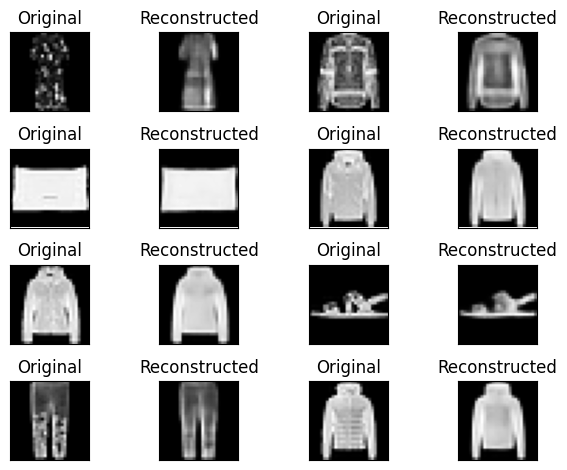

In [31]:
grid_side = 4
_, axs = plt.subplots(grid_side, grid_side)
for i in range(grid_side):
    for j in range(0,grid_side,2):
        Z = X_ts[np.random.randint(0, len(X_ts))].reshape((1,lado,lado,1))
        Z_post = vae.predict(Z)
        axs[i,j].imshow(Z.reshape(lado,lado), cmap = 'gray')
        axs[i,j+1].imshow(Z_post.reshape(lado,lado), cmap = 'gray')
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)
        axs[i,j].set_title('Original')
        axs[i,j+1].get_xaxis().set_visible(False)
        axs[i,j+1].get_yaxis().set_visible(False)
        axs[i,j+1].set_title('Reconstructed')
        
plt.tight_layout()
plt.show()

También presentamos un gráfico con algunas imágenes generadas por el decoder a partir de datos aleatorios dentro de la media y desviación estándar establecidas en el modelo.

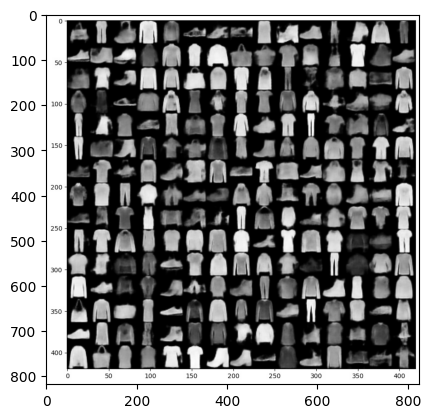

In [36]:
n = 15
figure = np.zeros((lado * n, lado * n))
for i in range(n):
    for j in range(n):
        z_artificial = np.array([np.random.normal(0,0.1,dim_latente)])
        x_recons = vae.get_decoder().predict(z_artificial, verbose = 0)
        x_recons = x_recons[0].reshape(lado, lado)
        figure[i * lado: (i + 1) * lado,
               j * lado: (j + 1) * lado] = x_recons

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap = 'gray')
plt.show()

#### Referencias
  - Bergmann, D., & Stryker, C. (2023, November 23). What is an autoencoder? | IBM. Www.ibm.com. https://www.ibm.com/topics/autoencoder
  - O’Connor, R. (2022, January 3). Introduction to Variational Autoencoders Using Keras. News, Tutorials, AI Research. https://www.assemblyai.com/blog/introduction-to-variational-autoencoders-using-keras/
  - Sancho Caparrini, F. (2020, March 2). Variational AutoEncoder. Cs.us.es. https://www.cs.us.es/~fsancho/Blog/posts/VAE.md